<a href="https://colab.research.google.com/github/stepanl-bsy/langgraph_tutorial/blob/main/4_lang_rewoo_task_planner_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

%pip install -q langgraph  langchain langchain_community langchain_google_genai tavily-python
# google-cloud-aiplatform vertexai langgraph langchain_google_vertexai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00


## Multiagent langgraph
 - Building Query Analysis tools


## What are Query Analysis patterns?
 - Query analysis tools help with situations where a user's responce is too vague or too complex or misses important information. These tools can be build as agent chains or langgraphs.
   - For example, a novice software user can ask a question without specifying crucial details. We might need to loop back and ask him/her for more info.
    - If what they have missed in their query is common knowledge, or if there is a very popular solution that they would probably want, we can also solve it - with HyDE query analysis pattern.
   - Imagine if the query is very complex and solving it involves multiple steps, with prior steps depending on the previous ones. This requires building a plan of tasks, then attempting to solve each task and then tying these all back together. This is what ReWOO query analysis pattern does

# Reasoning without Observation
Source: https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/rewoo/rewoo.ipynb


In [ReWOO](https://arxiv.org/abs/2305.18323), Xu, et. al, propose an agent that combines a multi-step planner and variable substitution for effective tool use. It was designed to improve on the ReACT-style agent architecture in the following ways:

1. Reduce token consumption and execution time by generating the full chain of tools used in a single pass. (_ReACT-style agent architecture requires many LLM calls with redundant prefixes (since the system prompt and previous steps are provided to the LLM for each reasoning step_)
2. Simplify the fine-tuning process. Since the planning data doesn't depend on the outputs of the tool, models can be fine-tuned without actually invoking the tools (in theory).


The following diagram outlines ReWOO's overall computation graph:



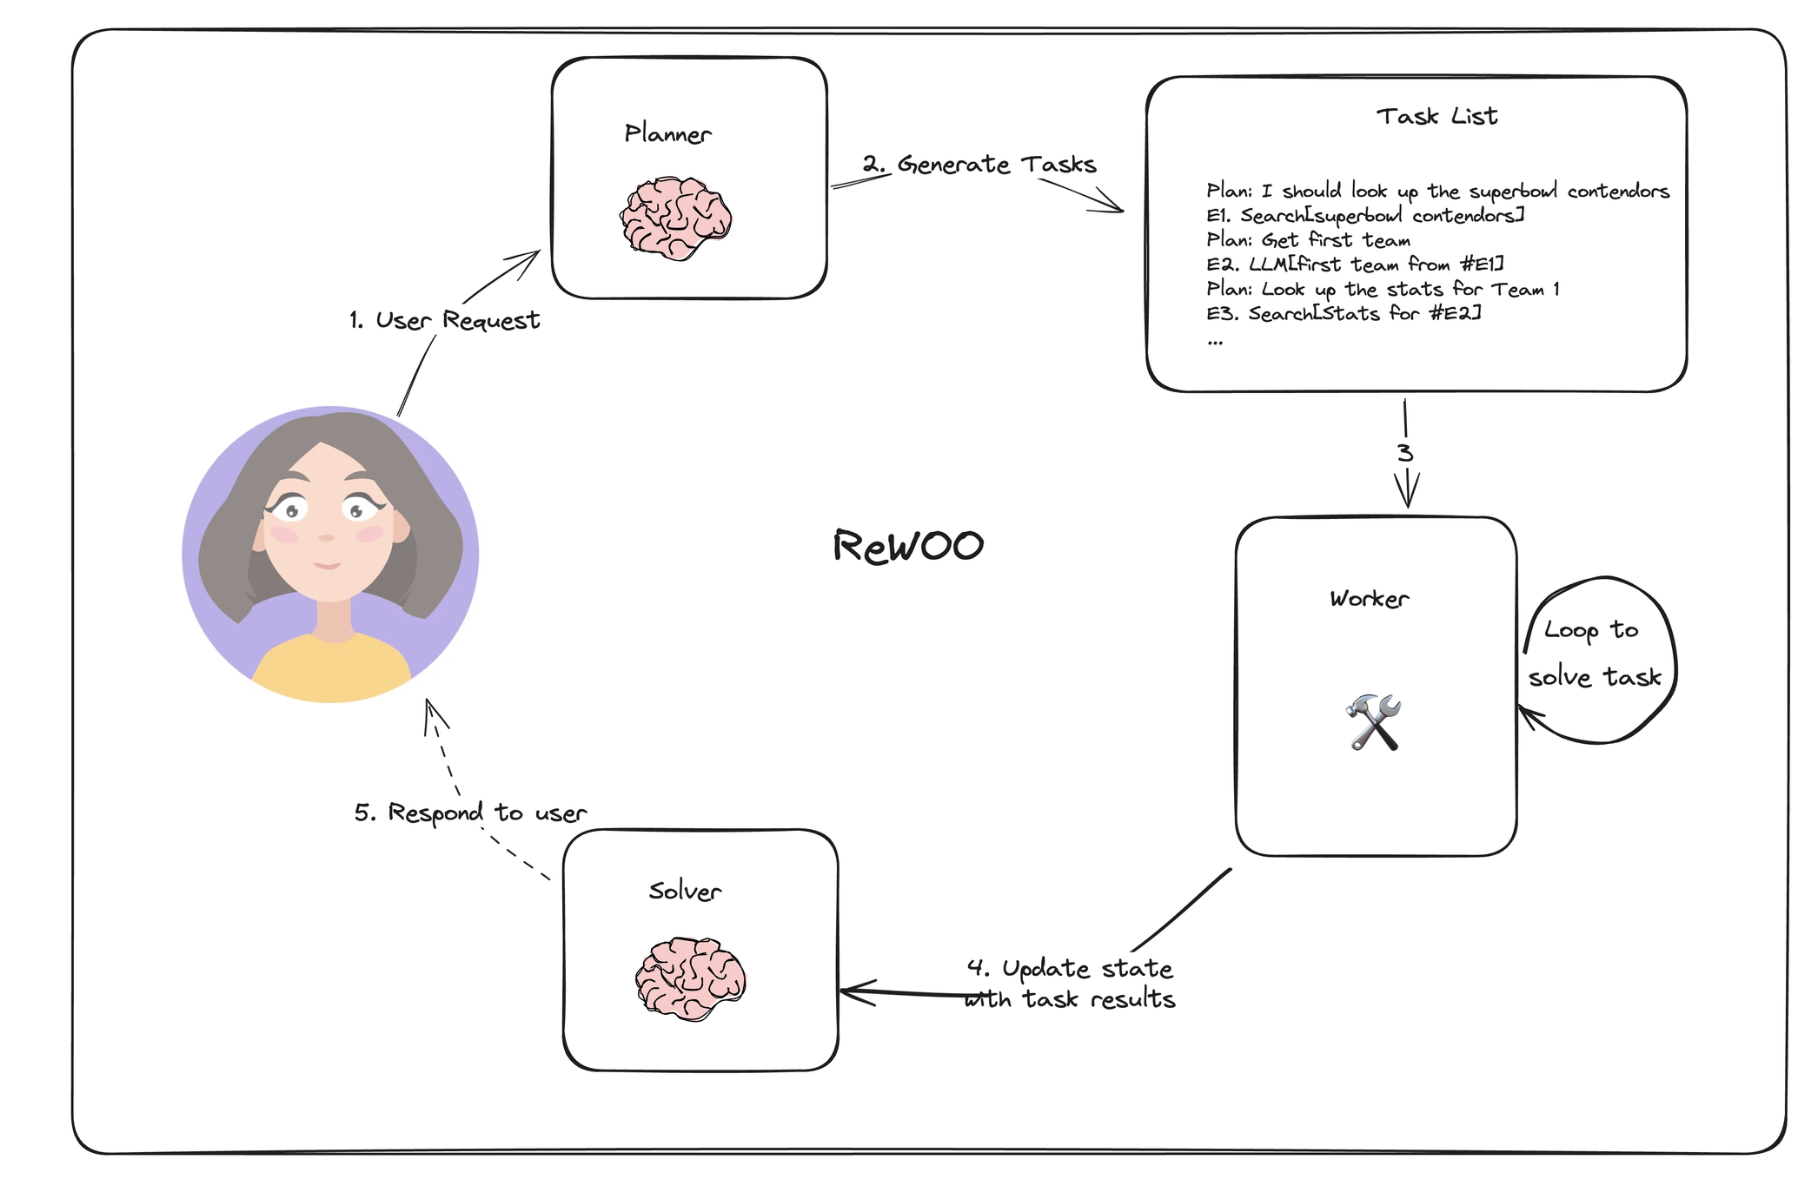


ReWOO is made of 3 modules:

1. 🧠**Planner**: Generate the plan in the following format:
```text
Plan: <reasoning>
#E1 = Tool[argument for tool]
Plan: <reasoning>
#E2 = Tool[argument for tool with #E1 variable substitution]
...
```
3. **Worker**: executes the tool with the provided arguments.
4. 🧠**Solver**: generates the answer for the initial task based on the tool observations.

The modules with a 🧠 emoji depend on an LLM call. Notice that we avoid redundant calls to the planner LLM by using variable substitution.

In this example, each module is represented by a LangGraph node. The end result will leave a trace that looks [like this one](https://smith.langchain.com/public/39dbdcf8-fbcc-4479-8e28-15377ca5e653/r). Let's get started!

## Setup

For this example, we will provide the agent with a Tavily search engine tool. You can get an API key [here](https://app.tavily.com/sign-in) or replace with a free tool option (e.g., [duck duck go search](https://python.langchain.com/docs/integrations/tools/ddg/)).

Let's install the required packages and set our API keys

## Define graph state

In LangGraph, every node updates a shared graph state. The state is the input to any node whenever it is invoked.

Below, we will define a state dict to contain the task, plan, steps, and other variables.

In [2]:
from typing import List
from typing_extensions import TypedDict


class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

## Planner

The planner prompts an LLM to generate a plan in the form of a task list. The arguments to each task are strings that may contain special variables (`#E{0-9}+`) that are used for variable substitution from other task results.



Our example agent will have two tools:
1. Google - a search engine (in this case Tavily)
2. LLM - an LLM call to reason about previous outputs.

The LLM tool receives less of the prompt context and so can be more token-efficient than the ReACT paradigm.

In [4]:


# ### LLM setup
# PROJECT_ID = "seequent-labs-dev"  # @param {type:"string"}
# LOCATION = "us-west1"  # @param {type:"string"}

# import vertexai

# vertexai.init(project=PROJECT_ID, location=LOCATION)
# from langchain_google_vertexai import ChatVertexAI

# # model = ChatVertexAI(model="gemini-1.5-pro-001",temperature=1)
# model = ChatVertexAI(model="gemini-1.5-flash-001",temperature=0.3)




In [5]:
import getpass
import os
import re


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}=")


_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("GOOGLE_API_KEY")

TAVILY_API_KEY=··········
GOOGLE_API_KEY=··········


In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

In [13]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...). There should be many plans, \
so that the task can be explored in-depth.

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
Don't excpect the search results to contain information unrelated to the current search result.
Instead, run additional searches to retrieve more information on related topics.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.


**Format:**

Plan: [Plan Description] #E[Number] = [ToolName][[ToolInput]]

Where:
* [Plan Description] is a detailed description of the plan. It should be as detailed as possible.
* [Number] is a sequential integer (1, 2, 3...).
* [ToolName] is one of: Google, LLM.
* [ToolInput] is the input for the specified tool.  Use #En to reference previous results.


**Tools:**
(1) Google[input]: Searches Google. Input is a search query.
(2) LLM[input]: Uses an LLM. Input is an instruction.
(3) Calculator[input]: Performs calculations. Input is a mathematical expression.


**Example:**

Task: What is 2 + 2?
Plan: Add 2 and 2. #E1 = LLM[2 + 2]

**Example:**
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin!
Describe your plans with rich details. Each plan MUST follow the EXACTLY the specified format. Each Plan should be followed by only one #E.

Task: {task}"""



In [14]:
# task = "how to create a block model in leapfrog"
task = "what is the exact hometown of the 2024 mens australian open winner"
task = "provide instructions on how to create an interpolated mesh in leapfrog geo for a newbie"



In [15]:
result = model.invoke(prompt.format(task=task))

In [16]:
print(result.content)

Plan: Understand the basic concepts of mesh interpolation in a 3D modeling software like LeapFrog Geo. #E1 = LLM[Explain mesh interpolation in 3D modeling software, focusing on the concepts and purpose.  Provide examples of when it's useful.]

Plan: Identify the specific tools and functionalities within LeapFrog Geo that are relevant to mesh interpolation. #E2 = Google["LeapFrog Geo mesh interpolation tutorial"]

Plan: Find a beginner-friendly tutorial or documentation on mesh interpolation within LeapFrog Geo.  Prioritize video tutorials. #E3 = Google["LeapFrog Geo mesh interpolation tutorial for beginners", "LeapFrog Geo mesh interpolation YouTube tutorial"]

Plan:  If no beginner-friendly tutorials are found, break down the process into smaller, manageable steps.  Start with importing the data. #E4 = LLM[Assuming I have two point clouds in LeapFrog Geo, describe the step-by-step process of importing them, ensuring the data is correctly formatted and ready for interpolation.]

Plan: 

#### Planner Node

To connect the planner to our graph, we will create a `get_plan` node that accepts the `ReWOO` state and returns with a state update for the
`steps` and `plan_string` fields.

In [17]:
import re

from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]  It's a very strict regex, so didn't work for gemini on the first try (I had to modify the planner prompt)
regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | model   #LCEL experssion that feeds the prompt template to the model https://python.langchain.com/v0.1/docs/expression_language/


def get_plan(state: ReWOO):
    """
    Parses the original model plan into a dictionary of steps {'steps': matches, 'plan_string': result.content},
    where:
     - matches = a list of tasks to execute parsed from the raw llm responce via regex, for example:
         [("Identify the winner of the 2024 Australian Open Men's Singles. ", '#E1', 'Google', '"2024 Australian Open Men\'s Singles winner"'), ('Find the hometown of the winner identified in #E1. ', '#E2', 'Google', '"Hometown of [winner\'s name from #E1')]
        {'plan': {'plan_string': 'Plan: Identify the winner of the 2024 Australian Open Men\'s Singles. #E1 = Google["2024 Australian Open Men\'s Singles winner"]\nPlan: Find the hometown of the winner identified in #E1. #E2 = Google["Hometown of [winner\'s name from #E1]"] \n', 'steps': [("Identify the winner of the 2024 Australian Open Men's Singles. ", '#E1', 'Google', '"2024 Australian Open Men\'s Singles winner"'), ('Find the hometown of the winner identified in #E1. ', '#E2', 'Google', '"Hometown of [winner\'s name from #E1')]
     - result.content:
         raw llm result (unparsed)
    This way, we can tackle these independently and insert results back into the original plan
    """
    task = state["task"]
    print(f'state[task]: {task}')  # some printouts for traceability

    result = planner.invoke({"task": task})  # note how task is fed into LCEL-defined planner.
    # This will take the prompt_template, substitute the task "what is the exact hometown of the 2024 mens australian open winner" in it,
    # and invoke the llm

    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)
    print(f'steps matches: {result.content}')
    return {"steps": matches, "plan_string": result.content}  # the return here will become key-value entries in the state dictionary
                                                              # can be accessed in later nodes as as state['steps'] and state['plan_string']

## Executor

The executor receives the plan and executes the tools in sequence.

Below, instantiate the search engine and define the tool execution node.

In [18]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults()


import time
import random

def call_tavily(tool_input):
    delay = 1
    max_retries = 5  # Adjust as needed

    for attempt in range(max_retries):
        try:
            result = search.invoke(tool_input)
            return result
        except HTTPError as e:
            if e.code == 429:  # Check for rate limit error (Too Many Requests)
                delay *= 2  # Double the delay
                jitter = random.uniform(0, 1)  # Add some randomness (jitter)
                time.sleep(delay + jitter)
            else:
                raise  # Re-raise the exception if it's not a rate limit error
    raise Exception("Failed after multiple retries due to rate limiting") # Raise an exception if all retries fail

In [19]:
def _get_current_task(state: ReWOO):
    """
    Keep track of the step index (count from 1, since llms' output responces in this format)
    """
    if "results" not in state or state["results"] is None:
        return 1  # no steps have been completed yet, so start on step #1 (since llm's will index from 1 - i.e. 1,2,3...)
    if len(state["results"]) == len(state["steps"]):
        return None         # all steps have been completed
    else:
        return len(state["results"]) + 1  # some steps have been completed but not all, thus go to next task


def tool_execution(state: ReWOO):
    """This code implements a simple workflow engine that executes a predefined sequence of steps involving Google searches and
    LLM queries, allowing later steps to build upon the results of earlier steps.
    The state dictionary acts as the central store for both the plan definition (steps) and the accumulated results (results).
    """
    _step = _get_current_task(state)   # get current step index
    _, step_name, tool, tool_input = state["steps"][_step - 1]  # access the step dictionary (generated by get_plan()) and extract
    # step name, tool and tool input
    # For example: step_name: #E1, tool:Google, tool_input:"2024 Australian Open men's singles winner"



    _results = (state["results"] or {}) if "results" in state else {}  # handles the case where no results have been generated yet - set it to empty dict
    for k, v in _results.items():
        """
        This loop iterates through the existing results and substitutes any placeholders in the tool_input string.
        For example, if tool_input is "What is the capital of #E1?" and _results contains {"#E1": "France"}, the tool_input will become "What is the capital of France?".
        This allows later steps to use the outputs of previous steps as input.
        """
        tool_input = tool_input.replace(k, v)

#     print('---'*5)
#     print('Tool inputs without evidence/ tool name substitutions')
#     print(f'step_name: {step_name}, \n tool:{tool}, \n tool_input:{tool_input}')
#     print('---'*5)

    if tool == "Google":       # invoke correct tool based on the tool name (we only have Google or LLM as options here, but we could have a lot more options)
        # result = search.invoke(tool_input)
        result = call_tavily(tool_input)
    elif tool == "LLM":
        result = model.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}  # output results string back into the state dict, so that we can access it in later nodes as state['results']

## Solver

The solver receives the full plan and generates the final response based on the responses of the tool calls from the worker.

In [20]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""


def solve(state: ReWOO):
    """
    This code takes the planned steps and their corresponding results, formats them into a comprehensive prompt,
    and then asks the language model to solve the original task based on this information.
    The key improvement over a simpler approach is the dynamic substitution of placeholders in both the tool inputs and step names,
    ensuring the language model receives the actual evidence gathered during each step, rather than just the initial planned inputs.
    This allows the model to reason over the outcomes of the steps, making the process more robust and accurate.
    """
    plan = ""   # empty plan string, so that the plan can be accumulated
    for _plan, step_name, tool, tool_input in state["steps"]:
        # Each step is a tuple of 4 elements, we diregard the first element and keep the rest:
        # For example: step_name: #E1, tool:Google, tool_input:"2024 Australian Open men's singles winner"

        _results = (state["results"] or {}) if "results" in state else {}  # handle the case where results don't exist
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
            """
            This loop is crucial. It substitutes placeholders (like #E1, #E2, etc.) in both the tool_input and
            the step_name with the corresponding values from the _results dictionary.
            This allows for dynamic construction of the plan string, reflecting the actual evidence gathered.
            """
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
        """
        Appends a formatted string representing the current step to the plan string.
        Notice how the substituted step_name and tool_input are used here.
        We should get a properly formatted and substituted Plan string as a result.
        For example,

        """
        print('---'*5)
        print('Plan with Evidence and tool_input substituted\n')
        print(f'_plan: {_plan}, \n step_name: {str(step_name)[:1000]}, \n tool:{str(tool)[:1000]}, \n tool_input:{tool_input[:1000]} \n')
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = model.invoke(prompt)
    print(f'result.content: {result.content}\n')
    print('---'*5)

    return {"result": result.content}

## Define Graph

Our graph defines the workflow. Each of the planner, tool executor, and solver modules are added as nodes.

In [21]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

In [22]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

In [23]:
task = "how to create a block model in leapfrog"
# task = "what is the exact hometown of the 2024 mens australian open winner"


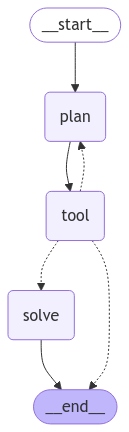

In [24]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [25]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

state[task]: how to create a block model in leapfrog
steps matches: Plan: Understand the basics of block modeling in Leapfrog Geo.  #E1 = Google["Leapfrog Geo block modeling tutorial"]

Plan: Identify the necessary data required for block modeling in Leapfrog Geo (e.g., drillhole data, assay data, geological interpretations). #E2 = LLM[List the data requirements for creating a block model in Leapfrog Geo, including data formats and necessary preprocessing steps.]

Plan: Learn how to import and prepare the data in Leapfrog Geo. This includes checking data quality, handling missing values, and potentially transforming data formats. #E3 = Google["Leapfrog Geo data import and preprocessing"]

Plan: Define the block model parameters in Leapfrog Geo, such as block dimensions, orientation, and the extent of the model.  #E4 = LLM[Explain the parameters involved in defining a block model in Leapfrog Geo and their impact on the final model.]

Plan:  Learn how to create the block model in Leapfro

In [26]:
# Print out the final result
print(s["solve"]["result"])

Creating a block model in Leapfrog Geo involves several steps:

1. **Data Acquisition and Preparation:** Gather necessary data (drillhole data, assay data, geological interpretations, DEMs, etc.) in appropriate formats (CSV, XLSX, DXF, SHP, GeoTIFF, etc.).  Preprocess data by cleaning, transforming coordinates, verifying collar locations, processing downhole surveys, validating assay data, and digitizing lithological logs. Create geological surfaces using interpolation techniques if needed.

2. **Data Import and Preparation in Leapfrog Geo:** Import the prepared data into Leapfrog Geo. Check data quality, handle missing values, and transform data formats if necessary.

3. **Block Model Parameter Definition:** Define block dimensions (x, y, z), orientation, model extent, origin, interpolation method (inverse distance weighting, kriging, nearest neighbor, etc.), search radius/ellipsoid, and processing resolution.

4. **Block Model Creation:** Create the block model in Leapfrog Geo using 

## Conclusion

Congratulations on implementing ReWOO! Before you leave, I'll leave you with a couple limitations of the current implementation from the paper:

1. If little context of the environment is available, the planner will be ineffective in its tool use. This can typically be ameliorated through few-shot prompting and/or fine-tuning.
2. The tasks are still executed in sequence, meaning the total execution time is impacted by _every_ tool call, not just the longest-running in a given step. There is a way to execute tools in parallel, but won't cover it here due to complexity.
3. The planning is done only once, unlike in REACT (where each new step is re-planned over and over again). This means if the plan doesn't work, we're out of luck. A possible improvement to this could be re-running a node or adding a fallback to more expensive REACT in case REWOO doesn't work.

## Other query analysis tools:
 - [Langchain query analysis]( https://python.langchain.com/v0.1/docs/use_cases/query_analysis/)
 - These keep changing and getting better all the time. That link is deprecated actually (old langchain version)
 - Some tools are better then other. Here's how OpenAI evaluated accuracy at last years' dev day

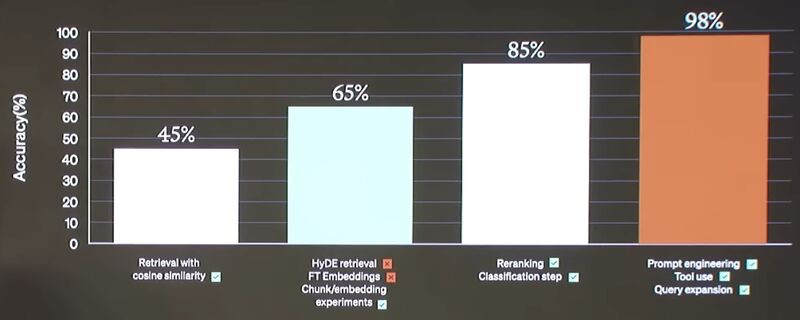

## Evaluation
Tool Usage tasks are designed to evaluate how well an agent can use tools to accomplish an objective.

Each task defines an environment in which the agent operates. The environment consists of a set of tools and a way to read the state of the environment (more on that below).

The tasks allow you to stress test the agent in different ways:

Can the agent use a single tool effectively?

Can the agent use more than 10 tools effectively?

Can the agent correctly incorporate information returned by the tool (and ignore internal knowledge)?

To help in this evaluation, each task is associated with a LangSmith dataset that includes input/output examples of varying difficulties.
 - https://langchain-ai.github.io/langchain-benchmarks/notebooks/tool_usage/intro.html?ref=blog.langchain.dev